In [24]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from models.MaskInference import MaskInference
from utils import utils, data
from pathlib import Path
import matplotlib.pyplot as plt

In [17]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "~/.nussl/tutorial/train"
val_folder = "~/.nussl/tutorial/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

In [18]:
nf = stft_params.window_length // 2 + 1
model = MaskInference.build(nf, 1, 50, 1, True, 0.0, 1, 'sigmoid')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

In [21]:
def train_step(batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    return loss.item() # return the loss for bookkeeping.

In [22]:
import tqdm

item = train_data[0] # Because of the transforms, this produces tensors.
batch = {} # A batch of size 1, in this case. Usually we'd have more.
for key in item:
    if torch.is_tensor(item[key]):
        batch[key] = item[key].float().unsqueeze(0)
    
N_ITERATIONS = 100
loss_history = [] # For bookkeeping

pbar = tqdm.tqdm(range(N_ITERATIONS))
for _ in pbar:
    loss_val = train_step(batch)
    loss_history.append(loss_val)
    pbar.set_description(f'Loss: {loss_val:.6f}')

Loss: 0.000465: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


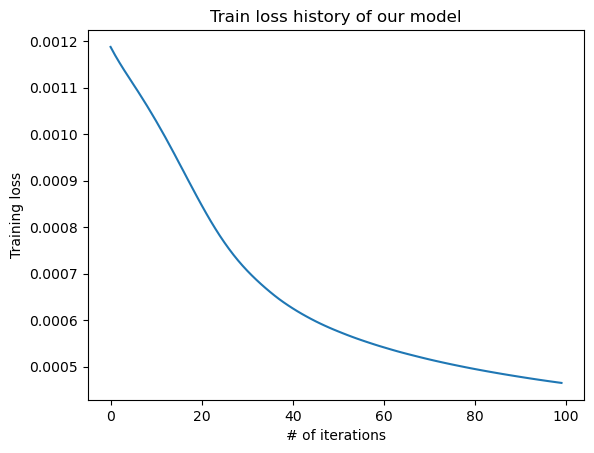

In [25]:
plt.plot(loss_history)
plt.xlabel('# of iterations')
plt.ylabel('Training loss')
plt.title('Train loss history of our model')
plt.show()